In [1]:
import sqlite3 as lite
import tweepy
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import re
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from pprint import pprint

In [7]:
con = lite.connect('TWEET_FDSHW.db')
cur = con.cursor()
cur.execute("DROP TABLE IF EXISTS TWEETS")
cur.execute("CREATE TABLE TWEETS(author text, created int, tweet text)")

In [8]:
consumer_key = "ra457hQdam5L9ORnlDg85SkZd"
consumer_key_secret = "mN0S5qEZyceFYjGPGLoUsqQpcb2InLJdpLdydxPNXeU1mrprcq"

access_token = "1504100659729215488-pJLy8eK5a7JYtnJFrxJm67yqKHKfy8"
access_token_secret = "jOt8nCfOFKCo4upsf8w4BAegLtlHfVuIf3vp2ENKYnPFN"

auth = tweepy.OAuthHandler(consumer_key, consumer_key_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

try:
    api.verify_credentials()
    print("Authentication OK")
except:
    print("Error during authentication")

Authentication OK


#### Investment topic: NFT’s

#### Using Tweepy/the Twitter API pull 200 tweets from each expert into a DB.

In [9]:
userlist = ['@DCLBlogger', '@punk6529', '@DeezeFi', '@wilxlee',\
            '@thebrettway', '@beeple', '@chriscantino', '@beaniemaxi', '@garyvee']

for i in range(0,len(userlist)):
    tweets = api.user_timeline(screen_name = userlist[i], count=200)
    tweets=tweepy.Cursor(api.search_full_archive, label='NFTSearch',
    query="CryptoPunks -is:retweet").items(1000)
    tweets = api.user_timeline(screen_name = userlist[i], count=200)
    for tweet in tweets:
        rowi = (tweet.author.screen_name, int(tweet.created_at.strftime("%Y%m%d")), tweet.text)
        cur.execute("INSERT OR IGNORE INTO TWEETS VALUES( ?, ?, ?)",rowi)
con.commit()

In [10]:
Qry = '''SELECT * FROM tweets'''
df = pd.read_sql_query(Qry, con)
df

,author,created,tweet
0,DCLBlogger,20220610,@borgetsebastien @Chris_Perdek @Uniqly_io @the...
1,DCLBlogger,20220610,RT @borgetsebastien: 👋 GM from Poland. Just ha...
2,DCLBlogger,20220609,"@Elliott_Randall Yes, been moving houses too s..."
3,DCLBlogger,20220609,Been off NFT Twitter for 5 days.\n\nWhat did I...
4,DCLBlogger,20220606,RT @themetakey: Team work makes the dream work...
...,...,...,...
1616,garyvee,20220522,@meekins_nft @astirSID
1617,garyvee,20220522,@lndnNFT @HendraWTX Yes much will be pondered ...
1618,garyvee,20220522,RT @loicRambo: @garyvee This is what happens w...
1619,garyvee,20220522,@obiwonkanoobie @astirSID


#### Word Cloud and topic modelling analysis on the tweets - reporting the resulting model for 2 topics.

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/matthewtorretta/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


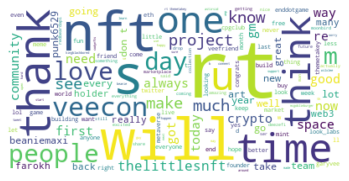

[(0,
  '0.021*"rt" + 0.005*"thelittlesnft" + 0.004*"veecon" + 0.004*"nft" + '
  '0.004*"thanks" + 0.004*"one" + 0.003*"love" + 0.003*"beaniemaxi" + '
  '0.003*"thank" + 0.003*"gm"'),
 (1,
  '0.016*"rt" + 0.007*"nft" + 0.005*"like" + 0.004*"time" + 0.004*"look_labs" '
  '+ 0.004*"web" + 0.004*"think" + 0.003*"people" + 0.003*"nfts" + '
  '0.003*"thelittlesnft"')]


In [11]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc))
        if word not in stop_words] for doc in texts]

if __name__ == '__main__':
    
    cnx = lite.connect('TWEET_FDSHW.db')
    tweets = '''SELECT * FROM tweets'''
    tweets = pd.read_sql_query(tweets, cnx)
    
    tweets['tweet_processed'] = tweets['tweet'].map(lambda x: re.sub('[,\.!?]', '', x))
    tweets['tweet_processed'] = tweets['tweet_processed'].map(lambda x: re.sub(r'http\S+', '', x))
    tweets['tweet_processed'] = tweets['tweet_processed'].map(lambda x: x.lower())
 
    long_string = ','.join(list(tweets['tweet_processed'].values))
   
    wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

    wordcloud.generate(long_string)
    nltk.download('stopwords')
    stop_words = stopwords.words('english')
    data = tweets.tweet_processed.values.tolist()
    data_words = list(sent_to_words(data))

    data_words = remove_stopwords(data_words)
    id2word = corpora.Dictionary(data_words)
    texts = data_words
    corpus = [id2word.doc2bow(text) for text in texts]

    num_topics = 2 
    lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=num_topics)
    
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    
    pprint(lda_model.print_topics())
    
    wordcloud.to_file('N.png')

In [12]:
con.close()